# Enhanced Singular Value Decomposition (ESVD)
Based on a [journal article](http://ieeexplore.ieee.org/document/8119909/) from IEEE.

In [1]:
# Import Modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split as tts
import scipy as sp

mat_print = lambda mat, name : print(mat, "\t <-----", name)

from sklearn.metrics import mean_squared_error as mse
rmse = lambda truth, pred : mse(truth, pred, squared=False)

%load_ext autoreload
%autoreload 2

In [2]:
# Prepare dataset

# Uncomment this to download dataset
# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip
# !mv ml-100k ML-100K
# !rm ml-100k.zip

os.chdir(os.path.join(os.getcwd(), "ML-100K"))
os.listdir()

['v_weights100k-3.npy',
 'v_weights100k-2.npy',
 'u.item',
 'u3.test',
 'train_loss_100k.npy',
 'u1.base',
 'v_weights100k-1.npy',
 'u.info',
 'v_weights100k-4.npy',
 'u2.test',
 'u5.test',
 'u.genre',
 'v_weights100k.npy',
 'u_weights100k-4.npy',
 'ub.test',
 'u_weights100k-3.npy',
 'ua.base',
 'u_weights100k-2.npy',
 'u.data',
 'u_weights100k-1.npy',
 'README',
 'u4.test',
 'train_loss_100k-2.npy',
 'u5.base',
 'train_loss_100k-3.npy',
 'train_loss_100k-1.npy',
 'ub.base',
 'train_loss_100k-4.npy',
 'ua.test',
 'u4.base',
 'u.user',
 'allbut.pl',
 'u3.base',
 'u1.test',
 'mku.sh',
 'u_weights100k.npy',
 'u2.base',
 'utility_matrix.npy',
 'u.occupation']

In [3]:
# Read all the TSV files for the dataset
data = pd.read_csv("u.data", delimiter="\t", names=["user_id", "movie_id", "rating", "timestamp"])
data

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [4]:
# Do a train-test-split of 70-30
print("Original dataset N:", data.shape[0])
train_df, test_df = tts(data, train_size=0.7, test_size=0.3, shuffle=True)
print("Train Data N:", train_df.shape[0])
print("Test Data N:", test_df.shape[0])

Original dataset N: 100000
Train Data N: 70000
Test Data N: 30000


Later on, $N$ and $N'$ will be used as parameters for the ESVD algorithm.

### Preparing the Utility Matrix
Since the data is in table form, we need to restructure it to match the utility matrix specification that follows:

$R_{n \times m}$

where $R$ is the utility matrix, $n$ is the number of users and $m$ is the number of movies.

For this matrix, we will be labelling missing entries as $0$ since it is outside of the movie rating scale that only stems from $1 - 5$.

In [5]:
# Create matrix of appropriate sizecount

# A proper index map should be created here. Change this from using max() to the actual count.
utility_R = np.zeros((train_df["user_id"].max(), train_df["movie_id"].max()))
print("Train Matrix Shape:", utility_R.shape)

utility_R_test = np.zeros((test_df["user_id"].max(), test_df["movie_id"].max()))
print("Test Matrix Shape:", utility_R_test.shape)

Train Matrix Shape: (943, 1682)
Test Matrix Shape: (943, 1680)


In [6]:
# Populate matrix with ratings
for i, row in train_df.iterrows():
    utility_R[int(row["user_id"]) - 1, int(row["movie_id"]) - 1] = row["rating"]

for i, row in test_df.iterrows():
    utility_R_test[int(row["user_id"]) - 1, int(row["movie_id"]) - 1] = row["rating"]

In [7]:
# Remove rows and columns that do not have any entries in them
# utility_R = utility_R[:, ~np.all(utility_R == 0, axis=0)]
# utility_R = utility_R[~np.all(utility_R == 0, axis=1), :]
# utility_R_test = utility_R_test[:, ~np.all(utility_R_test == 0, axis=0)]
# utility_R_test = utility_R_test[~np.all(utility_R_test == 0, axis=1), :]
print("Train Utility Matrix Shape:", utility_R.shape)
print("Test Utility Matrix Shape:", utility_R_test.shape)

Train Utility Matrix Shape: (943, 1682)
Test Utility Matrix Shape: (943, 1680)


In [8]:
print("Train Utility Matrix Density:", np.count_nonzero(utility_R) / (utility_R.shape[0] * utility_R.shape[1]))
print("Test Utility Matrix Density:", np.count_nonzero(utility_R_test) / (utility_R_test.shape[0] * utility_R_test.shape[1]))

mat_print(utility_R, "Training Utility Matrix")
mat_print(utility_R_test, "Testing Utility Matrix")

Train Utility Matrix Density: 0.044132685549571726
Test Utility Matrix Density: 0.018936524768974398
[[0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 	 <----- Training Utility Matrix
[[5. 3. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]] 	 <----- Testing Utility Matrix


In [9]:
# Double check all ratings complete
print("Train Present ratings:", np.count_nonzero(utility_R))
print("Train Missing ratings:", np.count_nonzero(utility_R==0))

print("Test Present ratings:", np.count_nonzero(utility_R_test))
print("Test Missing ratings:", np.count_nonzero(utility_R_test==0))

Train Present ratings: 70000
Train Missing ratings: 1516126
Test Present ratings: 30000
Test Missing ratings: 1554240


## Training

### Step 1: Density Parameters & Top Users and Movies
For data preprocessing, we need to derive the following insights based on the needs of the Enhanced Singular Value Decomposition algorithm:
1. Get the top $N$ most rated movies
2. Get the top $N'$ most active users (users with the most movies rated)

In [10]:
popular_movies = train_df.groupby("movie_id")["rating"].count().sort_values(ascending=False)
popular_movies_list = list(map(lambda idx: idx - 1, popular_movies.index.tolist())) # convert from 1-indexing to 0-indexing
popular_movies # N

movie_id
50      405
288     364
181     356
286     345
258     341
       ... 
1557      1
1332      1
1561      1
1562      1
1682      1
Name: rating, Length: 1629, dtype: int64

In [11]:
active_users = train_df.groupby("user_id")["rating"].count().sort_values(ascending=False)
active_users_list = list(map(lambda idx: idx - 1, active_users.index.tolist())) # convert from 1-indexing to 0-indexing
active_users # N prime

user_id
405    502
655    479
13     462
450    373
234    368
      ... 
549     12
725     11
651     11
558     10
310     10
Name: rating, Length: 943, dtype: int64

### Step 2: Initializing Submatrices
Now that it is time to initialize the submatrices, we now need to define the values for $N$ and $N'$. We will give its value via a percentage ratio from the actual dataset.

In [12]:
# Get the 25% of the most rated movies
n = n_prime = len(popular_movies_list) // 4
n

407

In [13]:
# M2
active_users_list = active_users_list[0:n_prime]
sub_matrix_user = utility_R[active_users_list, :]
sub_matrix_user

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 3., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [14]:
# M1
popular_movies_list = popular_movies_list[0:n]
sub_matrix_movies = utility_R[:, popular_movies_list]
sub_matrix_movies

array([[5., 0., 5., ..., 1., 3., 0.],
       [5., 3., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 5., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.]])

In [15]:
print("Submatrices shapes (M1, M2): ", sub_matrix_movies.shape, sub_matrix_user.shape)
print("Missing values in latent factors (movies, user):", np.count_nonzero(sub_matrix_movies==0), np.count_nonzero(sub_matrix_user==0))

Submatrices shapes (M1, M2):  (943, 407) (407, 1682)
Missing values in latent factors (movies, user): 334046 629555


### Step 3: Finding the Intersection of Popular Movies & Active Users
Now that we have found the most popular movies (most rated) and most active users, it's time to find their intersection, so we can get their ratings.

In [16]:
# M3: for this matrix, we need to find where M1 and M2 intersect
intersection_matrix = np.zeros(utility_R.shape)

for i in range(n):
    for j in range(n):
        intersection_matrix[i,j] = utility_R[active_users_list[i], popular_movies_list[j]]

# Reduce size
intersection_matrix = intersection_matrix[:, ~np.all(intersection_matrix == 0, axis=0)]
intersection_matrix = intersection_matrix[~np.all(intersection_matrix == 0, axis=1), :]
print("Intersection matrix shape:", intersection_matrix.shape)
mat_print(intersection_matrix, "Intersection Matrix")
print("Intersection Matrix Density:", np.count_nonzero(intersection_matrix) / (intersection_matrix.shape[0] * intersection_matrix.shape[1]))

Intersection matrix shape: (407, 407)
[[0. 5. 5. ... 0. 4. 5.]
 [4. 3. 3. ... 2. 2. 0.]
 [0. 0. 0. ... 3. 0. 3.]
 ...
 [4. 0. 0. ... 0. 0. 4.]
 [4. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 	 <----- Intersection Matrix
Intersection Matrix Density: 0.2286521500280714


### Step 4: Matrix Factorization (UV Decomposition) for Missing Values in the Intersection Matrix

To fill in the matrix above, we shall perform dimensionality reduction on the same matrix, to get the feature vectors $U$ and $V$. With these vectors, we can predict the values for the missing ratings.

Let's perform Regularized SVD using NumPy's built-in SVD method in its linear algebra module.

In [17]:
U, S, Vh = np.linalg.svd(intersection_matrix, full_matrices=True)
Sd = sp.linalg.diagsvd(S, *intersection_matrix.shape)
reconstructed_intersection = np.around(U @ Sd @ Vh, 2)
print("Are the factor matrices accurate? :", np.allclose(intersection_matrix, reconstructed_intersection))
reconstructed_intersection

Are the factor matrices accurate? : True


array([[ 0.,  5.,  5., ...,  0.,  4.,  5.],
       [ 4.,  3.,  3., ...,  2.,  2., -0.],
       [ 0.,  0.,  0., ...,  3.,  0.,  3.],
       ...,
       [ 4.,  0.,  0., ...,  0.,  0.,  4.],
       [ 4.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.]])

Now that we are sure that the factor matrices accurate within reasonable tolerance, we shall use the following equation to predict the missing ratings:

$\hat{r}_{ij} = (U\Sigma)_{i}V^T_{j}$

In [18]:
# Predict the rest of the values of the matrix
predicted_intersection = np.zeros(intersection_matrix.shape)
US = U @ Sd
for i in range(US.shape[0]):
    for j in range(Vh.shape[0]):
        if intersection_matrix[i,j] == 0:
            predicted_intersection[i,j] = np.abs(US[i,:] @ Vh.T[:,j])
        else:
            predicted_intersection[i,j] = intersection_matrix[i,j]
predicted_intersection

array([[0.40126356, 5.        , 5.        , ..., 3.32889814, 4.        ,
        5.        ],
       [4.        , 3.        , 3.        , ..., 2.        , 2.        ,
        0.1796135 ],
       [6.79613747, 0.39282021, 1.81382291, ..., 3.        , 0.07333712,
        3.        ],
       ...,
       [4.        , 1.85130605, 0.11950966, ..., 0.93514634, 1.04563072,
        4.        ],
       [4.        , 1.44119494, 3.        , ..., 1.0628045 , 1.2868025 ,
        0.95575755],
       [3.03110548, 0.34247859, 0.65357245, ..., 0.11320131, 0.39303998,
        2.17303781]])

### Step 5: Remapping the Generated Intersection Matrix Values to the Main Training Matrix
Now that we found the predicted ratings, we need to remap these values to the original matrix, then we can perform the SVD one more time before testing it on the test set.

In [19]:
u = k = 0
for i in active_users_list:
    k = 0
    for j in popular_movies_list:
        utility_R[i,j] = predicted_intersection[u,k]
        k += 1
    u += 1

Let us now check the density of the brand new utility matrix with some updated ratings.

In [20]:
print("Updated Utility Matrix Density:", np.count_nonzero(utility_R) / (utility_R.shape[0] * utility_R.shape[1]))

Updated Utility Matrix Density: 0.12468933741707784


We now have an updated density that is roughly 3 times the original density. 

### Step 6: Testing Against the Test Set
With a set of trained weights, we can now predict the missing ratings of the test set.

First, we need to match the dimensions of the test set and train set. To do this, we will pad the test set with zeros.

In [21]:
if utility_R_test.shape[1] < utility_R.shape[1]:
    # Pad the test
    padded_test = np.pad(utility_R_test, ((0, utility_R.shape[0] - utility_R_test.shape[0]), (0, utility_R.shape[1] - utility_R_test.shape[1])), 'constant')
    padded_test.shape
else:
    # Pad the train set
    padded_test = utility_R_test.copy()
    utility_R = np.pad(utility_R, ((0, utility_R_test.shape[0] - utility_R.shape[0]), (0, utility_R_test.shape[1] - utility_R.shape[1])), 'constant')

In [22]:
# Calculate density of the test set
print("Test Utility Matrix Density:", np.count_nonzero(padded_test) / (padded_test.shape[0] * padded_test.shape[1]))
print("Updated train size:", utility_R.shape)
print("Updated test size:", padded_test.shape)

Test Utility Matrix Density: 0.018914008092673597
Updated train size: (943, 1682)
Updated test size: (943, 1682)


Next, we shall perform RSVD on the updated utility train set to get our $U'$ and $V'$ weights.

In [23]:
U, S, Vh = np.linalg.svd(utility_R, full_matrices=True)
Sd = sp.linalg.diagsvd(S, *utility_R.shape)
utility_pred = np.around(U @ Sd @ Vh, 2)
utility_pred

array([[ 2.17,  1.9 ,  4.  , ...,  0.  , -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  , -0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 5.  , -0.  ,  0.  , ...,  0.  ,  0.  , -0.  ],
       [ 0.89,  4.62,  0.61, ...,  0.  , -0.  , -0.  ],
       [ 1.78,  1.74,  0.09, ...,  0.  , -0.  ,  0.  ]])

Apply the prediction to the test set's nonzero elements and get the RMSE.

In [24]:
test_prediction = np.zeros(padded_test.shape)
US = U @ Sd
for i in range(test_prediction.shape[0]):
    for j in range(test_prediction.shape[1]):
        # Predict
        test_prediction[i,j] = np.abs(US[i,:] @ Vh.T[:,j])
np.around(test_prediction, 2)

array([[4.41, 6.43, 4.76, ..., 0.  , 0.17, 0.1 ],
       [0.07, 0.22, 0.53, ..., 0.  , 0.13, 0.07],
       [0.17, 0.54, 1.72, ..., 0.  , 0.09, 0.02],
       ...,
       [0.28, 1.04, 0.37, ..., 0.  , 0.02, 0.06],
       [2.46, 4.27, 0.69, ..., 0.  , 0.2 , 0.15],
       [2.3 , 4.94, 3.24, ..., 0.  , 0.18, 0.2 ]])

In [25]:
print("RMSE From SKlearn's RMSE Function:", rmse(padded_test, test_prediction))

RMSE From SKlearn's RMSE Function: 0.7951128340358145


Let's calculate our own RMSE function based on the paper.

In [26]:
T = padded_test.shape[0] * padded_test.shape[1]
errors = np.sum((padded_test - test_prediction)**2)
calc_rmse = np.sqrt(errors / T)
calc_rmse

0.9704463119168542

We will follow the RMSE defined in the paper so we can compare our results with theirs.

## Bundling
To make the test phase easier, we shall bundle the code into a Python file.

Before jumping into testing & validation, let's run one more run of the same set of steps we did above, just now with the bundled module.

In [27]:
import ESVD
util = ESVD.fit(train_df, 0.25)
ESVD.test(util, test_df)

(0.9704463119168542,
 array([[4.40800739, 6.42787188, 4.75812686, ..., 0.        , 0.17096536,
         0.09938518],
        [0.06932096, 0.22258891, 0.53318447, ..., 0.        , 0.12525488,
         0.06803808],
        [0.1681364 , 0.53691192, 1.7172301 , ..., 0.        , 0.08532663,
         0.02265399],
        ...,
        [0.28113874, 1.04350939, 0.36927483, ..., 0.        , 0.02107114,
         0.05513463],
        [2.45744288, 4.26802772, 0.69438646, ..., 0.        , 0.20075411,
         0.14591756],
        [2.30027669, 4.94314498, 3.24060598, ..., 0.        , 0.17871092,
         0.19836103]]))

In [28]:
cal_rmse, pred = ESVD.train_and_test(train_df, test_df, 0.20)
print("RMSE:", cal_rmse)
np.around(pred, 2)

RMSE: 0.9420014257111312


array([[4.04, 2.58, 0.28, ..., 0.  , 0.13, 0.14],
       [0.27, 0.11, 0.79, ..., 0.  , 0.06, 0.12],
       [0.23, 0.31, 0.45, ..., 0.  , 0.05, 0.15],
       ...,
       [0.13, 0.3 , 0.44, ..., 0.  , 0.05, 0.  ],
       [1.03, 0.28, 1.17, ..., 0.  , 0.2 , 0.05],
       [2.11, 4.06, 0.57, ..., 0.  , 0.11, 0.19]])

## Testing & Validation
To validate the accuracy of the model, we will run K-Fold Cross-Validation.

First, we shall segment our original data dataframe into k segments.

In [29]:
# Shuffle dataframe
master_df = data.sample(frac=1)

In [30]:
# Define hyperparameters
K = 5
n_top = 0.2

# Split the master df to 5 sections
n = master_df.shape[0] // 5
dfs = []
for i in range(K):
    dfs.append(master_df[i*n : (i+1)*n])

In [31]:
for i in range(len(dfs)):
    print("Fold {i}:\n".format(i=i))
    print(dfs[i])

Fold 0:

       user_id  movie_id  rating  timestamp
37517      622        30       4  882670190
1659        49       625       3  888067031
52464      432       300       4  889415763
48783      498       447       3  882205321
92684      906       237       4  879435469
...        ...       ...     ...        ...
70848      704       648       5  891397667
69015      409      1512       5  881106947
76661      933       405       3  874939157
72060      913       174       5  881367620
34403      318        85       3  884497180

[20000 rows x 4 columns]
Fold 1:

       user_id  movie_id  rating  timestamp
60313      670       659       5  877974699
79699      711       155       4  879995382
70871      848       476       3  887047674
32554      561        53       3  885810538
42892      610       288       3  888702795
...        ...       ...     ...        ...
50255        7        68       4  891351547
9404       248       210       3  884534946
25332      271        98       5

In [32]:
# Run the round-robin
test_rmse_values = []
for fold in range(K):
    # Select test set
    test_set = dfs[fold]
    train_dfs = [x for i,x in enumerate(dfs) if i!=fold]
    train_set = pd.concat(train_dfs)
    cal_rmse, _ = ESVD.train_and_test(train_set, test_set, n_top)
    test_rmse_values.append(cal_rmse)
    print("Fold {fold} RMSE: {rmse}".format(fold=fold, rmse=cal_rmse))
print("Average RMSE:", np.mean(test_rmse_values))
test_rmse_values

Fold 0 RMSE: 0.9749295588767017
Fold 1 RMSE: 0.9711199313569032
Fold 2 RMSE: 0.9728367819450962
Fold 3 RMSE: 0.9728220671730281
Fold 4 RMSE: 0.9748322171360919
Average RMSE: 0.9733081112975643


[0.9749295588767017,
 0.9711199313569032,
 0.9728367819450962,
 0.9728220671730281,
 0.9748322171360919]

Text(0.5, 1.0, 'K-Fold Cross-Validation')

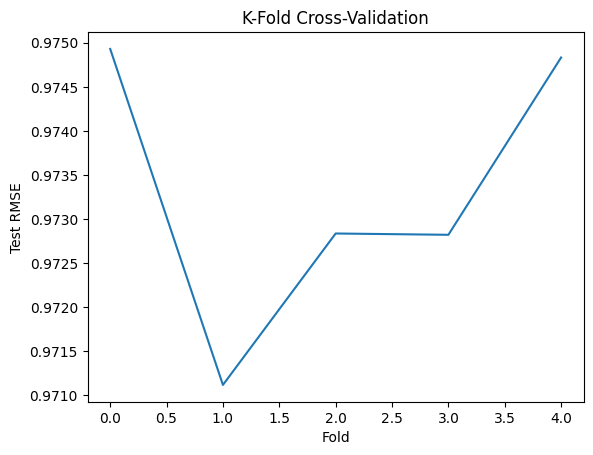

In [33]:
plt.plot(test_rmse_values)
plt.xlabel("Fold")
plt.ylabel("Test RMSE")
plt.title("K-Fold Cross-Validation")

And there we have it! The Enhanced-SVD model is trained and validated successfully on the MovieLens-100K dataset!

In [50]:
from UVD_GD import train_rmse

In [62]:
test_rmse_values = []
for fold in range(5):
    # Select test set
    test_set = dfs[fold]
    train_dfs = [x for i,x in enumerate(dfs) if i!=fold]
    train_set = pd.concat(train_dfs)
    
    train_util = ESVD.generate_utility_matrix(train_set)
    test_util = ESVD.generate_utility_matrix(test_set)
    
    train_util, test_util = ESVD.transform_train_test(train_util, test_util)
    
    _, u_w, v_w, loss_h = train_rmse(train_util, learning_rate=0.0001)
    
    pred = np.zeros(test_util.shape)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[0]):
            pred[i,j] = np.abs(u_w[i,:] @ v_w.T[:,j])
            
    cal_rmse = ESVD.rmse(test_util, pred)
    
    test_rmse_values.append(cal_rmse)
    print("Fold {fold} RMSE: {rmse}".format(fold=fold, rmse=cal_rmse))
print("Average RMSE:", np.mean(test_rmse_values))
test_rmse_values

Initialized parameters...
Initializing weights...
Initial weight: 0.18862534003492254
----------------------------------------------------------
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]] 	 <----- Ground Truth M
----------------------------------------------------------
Starting training with the following parameters:
alpha (lr): 0.0001
Precision threshold: 1e-06
Max epochs: 100
----------------------------------------------------------
Initial RMSE:  0.6372374640972173
Epoch 0 RMSE: 0.6371977150625435
Epoch 1 RMSE: 0.6371524660516565
Epoch 2 RMSE: 0.6371019380506425
Epoch 3 RMSE: 0.6370469731807638
Epoch 4 RMSE: 0.6369892969037323
Epoch 5 RMSE: 0.6369317895144339
Epoch 6 RMSE: 0.6368786937316367
Epoch 7 RMSE: 0.6368356361492344
Epoch 8 RMSE: 0.6368093044391452
Epoch 9 RMSE: 0.6368066505047486
Epoch 10 RMSE: 0.6368336450468689
------------------------------------------------

In [55]:
pred = np.zeros(test_util.shape)
for i in range(pred.shape[0]):
    for j in range(pred.shape[0]):
        pred[i,j] = np.abs(u_w[i,:] @ v_w.T[:,j])

In [56]:
pred

array([[2.6580155 , 1.24774792, 0.97134824, ..., 0.        , 0.        ,
        0.        ],
       [1.33757816, 0.62789715, 0.4888061 , ..., 0.        , 0.        ,
        0.        ],
       [1.10041926, 0.51656803, 0.40213848, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.06040876, 0.49778597, 0.38751699, ..., 0.        , 0.        ,
        0.        ],
       [1.60402192, 0.75297341, 0.58617561, ..., 0.        , 0.        ,
        0.        ],
       [2.09614693, 0.98399086, 0.76601834, ..., 0.        , 0.        ,
        0.        ]])

In [57]:
test_util

array([[0., 3., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
ESVD.rmse(test_util, pred)

Text(0.5, 1.0, 'UVD-GD Training RMSE')

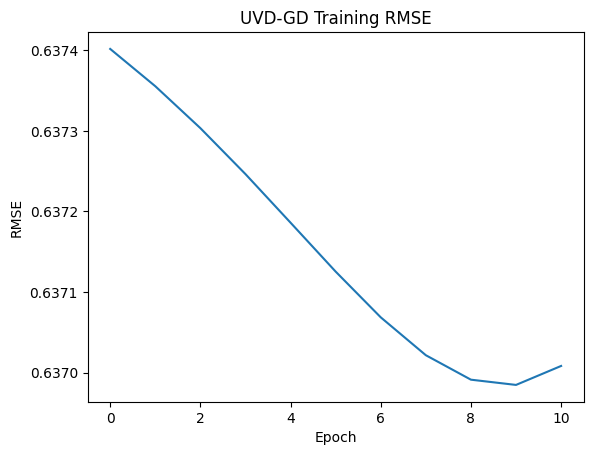

In [64]:
plt.plot(loss_h)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("UVD-GD Training RMSE")